# Correcting for multiple comparisons

Geoffrey Brookshire

Here we test how the AR surrogate and robust est. analyses behave when correcting for multiple comparisons using cluster-based permutation tests, Bonferroni corrections, and correcting with the False Discovery Rate (FDR).

In [1]:
# Import libraries and set up analyses
%matplotlib inline

import os
os.chdir('..')

In [2]:
import yaml
import copy
import itertools
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import analysis
import simulate_behavior as behav
import simulate_experiments as sim_exp
from analysis_methods import shuff_time, alternatives, utils
from generate_plots import remove_topright_axes
from stat_report_helpers import chi_square_report

# Suppress maximum likelihood estimation convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

USE_CACHE = True  # Whether to use previously-saved simulations

behav_details = yaml.safe_load(open('behav_details.yaml'))

plt.ion()

plot_dir = 'plots/'
n_exp = 1000
behav_kwargs = {'noise_method': 'powerlaw',
                'exponent': 2}
osc_parameters = {'Rand walk': {'f_osc': 0, 'osc_amp': 0},
                  'Rand walk + osc': {'f_osc': 6, 'osc_amp': 0.4}}
method_names = {'Robust est': 'mann_lees',
                'AR surr': 'ar'}

colors = {'Rand walk': 'red',
          'Rand walk + osc': 'dodgerblue'}

In [3]:
osc_parameters = {'Rand walk': {'f_osc': 0, 'osc_amp': 0},
                  'Rand walk + osc': {'f_osc': 6, 'osc_amp': 0.4}}
correction_methods = ('Cluster', 'Bonferroni', 'FDR')
exp_functions = {'Robust est': sim_exp.robust_est_experiment,
                 'AR surr': sim_exp.ar_experiment}
prop_signif = {}

for osc_label, osc_params in osc_parameters.items():
    prop_signif[osc_label] = {}
    
    for analysis_meth, exp_fnc in exp_functions.items():
        prop_signif[osc_label][analysis_meth] = {}

        for correction in correction_methods:
            
            # Can't run a cluster test on robust est.
            if analysis_meth == 'Robust est' and correction == 'Cluster':
                continue

            if correction == 'Cluster':  # Re-use main data for cluster
                desc = ''
            else:
                desc = f'-{correction}'

            def analysis_fnc(**behav_kwargs):
                """ Helper function
                """
                res = exp_fnc(correction=correction.lower(),
                              **behav_kwargs)
                return res

            if USE_CACHE or correction == 'Cluster':
                lit = analysis.load_simulation(method_names[analysis_meth],
                                               desc=desc,
                                               **behav_kwargs,
                                               **osc_params)

            else:

                lit = analysis.simulate_lit(analysis_fnc, n_exp,
                                            desc=desc,
                                            **behav_kwargs,
                                            **osc_params)
                analysis.save_simulation(lit,
                                         method_names[analysis_meth],
                                         desc=desc,
                                         **behav_kwargs,
                                         **osc_params)

            p = analysis.prop_sig(lit)
            prop_signif[osc_label][analysis_meth][correction] = p

loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00-Bonferroni.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00-FDR.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-Bonferroni.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-FDR.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40-Bonferroni.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40-FDR.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-Bonferroni.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-FDR.npy


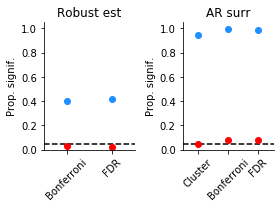

In [4]:
def prop_ci(p, n):
    """ 95% CI of a proportion
    """
    return 1.96 * np.sqrt((p * (1 - p)) / n)

fig, axes = plt.subplots(1, 2,
                         gridspec_kw={'width_ratios': [1, 1]},
                         figsize=(4, 3))

for i_plot, analysis_meth in enumerate(exp_functions.keys()):
    plt.subplot(axes[i_plot])
    plt.title(analysis_meth)
    plt.axhline(y=0.05, color='k', linestyle='--')
    for osc_label in osc_parameters.keys():
        psig = prop_signif[osc_label][analysis_meth]
        labels = psig.keys()
        x_pos = np.arange(float(len(psig)))
        psig = np.array(list(psig.values()))
        plt.errorbar(x_pos, psig,
                     yerr=prop_ci(psig, n_exp),
                     fmt='o',
                     color=colors[osc_label],
                     label=osc_label)
    plt.xticks(x_pos, labels, rotation=45)
    plt.xlim([-0.5, len(psig) - 0.5])
    plt.ylim(0, 1.05)
    plt.ylabel('Prop. signif.')
    remove_topright_axes()
plt.tight_layout()
plt.savefig(f"{plot_dir}mult_comp_corrections.eps")

These plots show the proportion of significant oscillations identified for each method of multiple comparisons correction. The false positive rate for each method is reflected in the proportion of significant results when the data were simulated as a random walk (in blue). The true positive rate (analogous to experimental power, assuming certain characteristics of the signal) is reflected in the proportion of significant results when the data were simulated as a random walk plus an oscillation (in orange).

## Statistical tests

### Differences between methods for multiple comparisons correction

We can test for differences in performance between the different methods of adjusting for multiple comparisons.

First, test whether the choice of multiple comparison influences the rate of positive results for the AR surrogate analysis.

In [5]:
analysis_meth = 'AR surr'
for osc_label in osc_parameters.keys():
    print('-', osc_label)
    psig = prop_signif[osc_label][analysis_meth]
    labels = psig.keys()
    tbl = []
    for mult_comp_meth, p in psig.items():
        row = [int(p * n_exp), int((1 - p) * n_exp)]
        tbl.append(row)
    tbl = np.array(tbl)
    msg = chi_square_report(tbl)
    print('  ' + msg)

- Rand walk
  $\chi^2(2) = 14.0$, $p = 0.0009$, $\phi_C = 0.07$ [0.04, 0.10]
- Rand walk + osc
  $\chi^2(2) = 55.0$, $p = 1 \times 10^{-12}$, $\phi_C = 0.14$ [0.10, 0.17]


Next, test for pairwise differences between multiple comparisons methods within each analysis method and signal type.

In [6]:
for analysis_meth in exp_functions.keys():
    print(analysis_meth)
    for osc_label in osc_parameters.keys():
        print('-', osc_label)
        psig = prop_signif[osc_label][analysis_meth]
        labels = psig.keys()
        for comp in itertools.combinations(labels, 2):
            # Make a contingency table
            p0 = psig[comp[0]]
            p1 = psig[comp[1]]
            tbl = [[p0 * n_exp, p1 * n_exp],
                   [(1 - p0) * n_exp, (1 - p1) * n_exp]]
            tbl = np.array(tbl)
            msg = f' - {comp[0][:3]} vs {comp[1][:3]}: '
            msg += chi_square_report(tbl)
            print(msg)

Robust est
- Rand walk
 - Bon vs FDR: $\chi^2(1) = 0.2$, $p = 0.7$, $\phi_C = 0.01$ [0.00, 0.06]
- Rand walk + osc
 - Bon vs FDR: $\chi^2(1) = 0.5$, $p = 0.5$, $\phi_C = 0.02$ [0.00, 0.06]
AR surr
- Rand walk
 - Clu vs Bon: $\chi^2(1) = 10.5$, $p = 0.001$, $\phi_C = 0.07$ [0.03, 0.12]
 - Clu vs FDR: $\chi^2(1) = 11.1$, $p = 0.0009$, $\phi_C = 0.08$ [0.03, 0.12]
 - Bon vs FDR: $\chi^2(1) = 0.0$, $p = 1$, $\phi_C = 0.00$ [0.00, 0.05]
- Rand walk + osc
 - Clu vs Bon: $\chi^2(1) = 34.0$, $p = 6 \times 10^{-09}$, $\phi_C = 0.13$ [0.10, 0.16]
 - Clu vs FDR: $\chi^2(1) = 26.1$, $p = 3 \times 10^{-07}$, $\phi_C = 0.12$ [0.08, 0.15]
 - Bon vs FDR: $\chi^2(1) = 0.6$, $p = 0.5$, $\phi_C = 0.02$ [0.00, 0.07]


### Comparing false positives against alpha = 0.05

Does each method have a rate of false positives higher than 0.05? If so, that method does not adequately control the rate of false positives.

In [7]:
for analysis_meth in exp_functions.keys():
    print(analysis_meth)
    psig = prop_signif['Rand walk'][analysis_meth]
    labels = psig.keys()
    for mc_meth, prop in psig.items():
        pval = stats.binom_test(prop * n_exp,
                                n_exp,
                                0.05,
                                alternative = 'greater')
        msg = f'- {mc_meth[:3]}: {prop:.2f}, '
        msg += f'p = {pval:.0e}'
        if prop > 0.05 and pval < 0.05:
            msg += ' *'
        print(msg)

Robust est
- Bon: 0.03, p = 1e+00
- FDR: 0.02, p = 1e+00
AR surr
- Clu: 0.04, p = 8e-01
- Bon: 0.08, p = 3e-05 *
- FDR: 0.08, p = 2e-05 *
